## Multi-Experiment Comparison

Multi-Experiment Comparison
✓ Loaded CRUD baseline: 20 samples
✓ Loaded DirectLLM baseline: 20 samples
['period2', 'period3', 'period4']
✓ Loaded experiment period4: 20 samples
✓ Loaded experiment period3: 20 samples
✓ Loaded experiment period2: 20 samples
📅 Experiments sorted by timestamp (left to right in charts):
   period2: period2
   period3: period3
   period4: period4

📊 Available metrics (intersection, in CSV order): 21
   overall_score, llm_judge_score, rejection_recall, ndcg, ncg, mrr, ndcg_at_3, ndcg_at_5, intermediate_ndcg, intermediate_ncg...
📝 Question types: Both, QA, Ranking, refusal


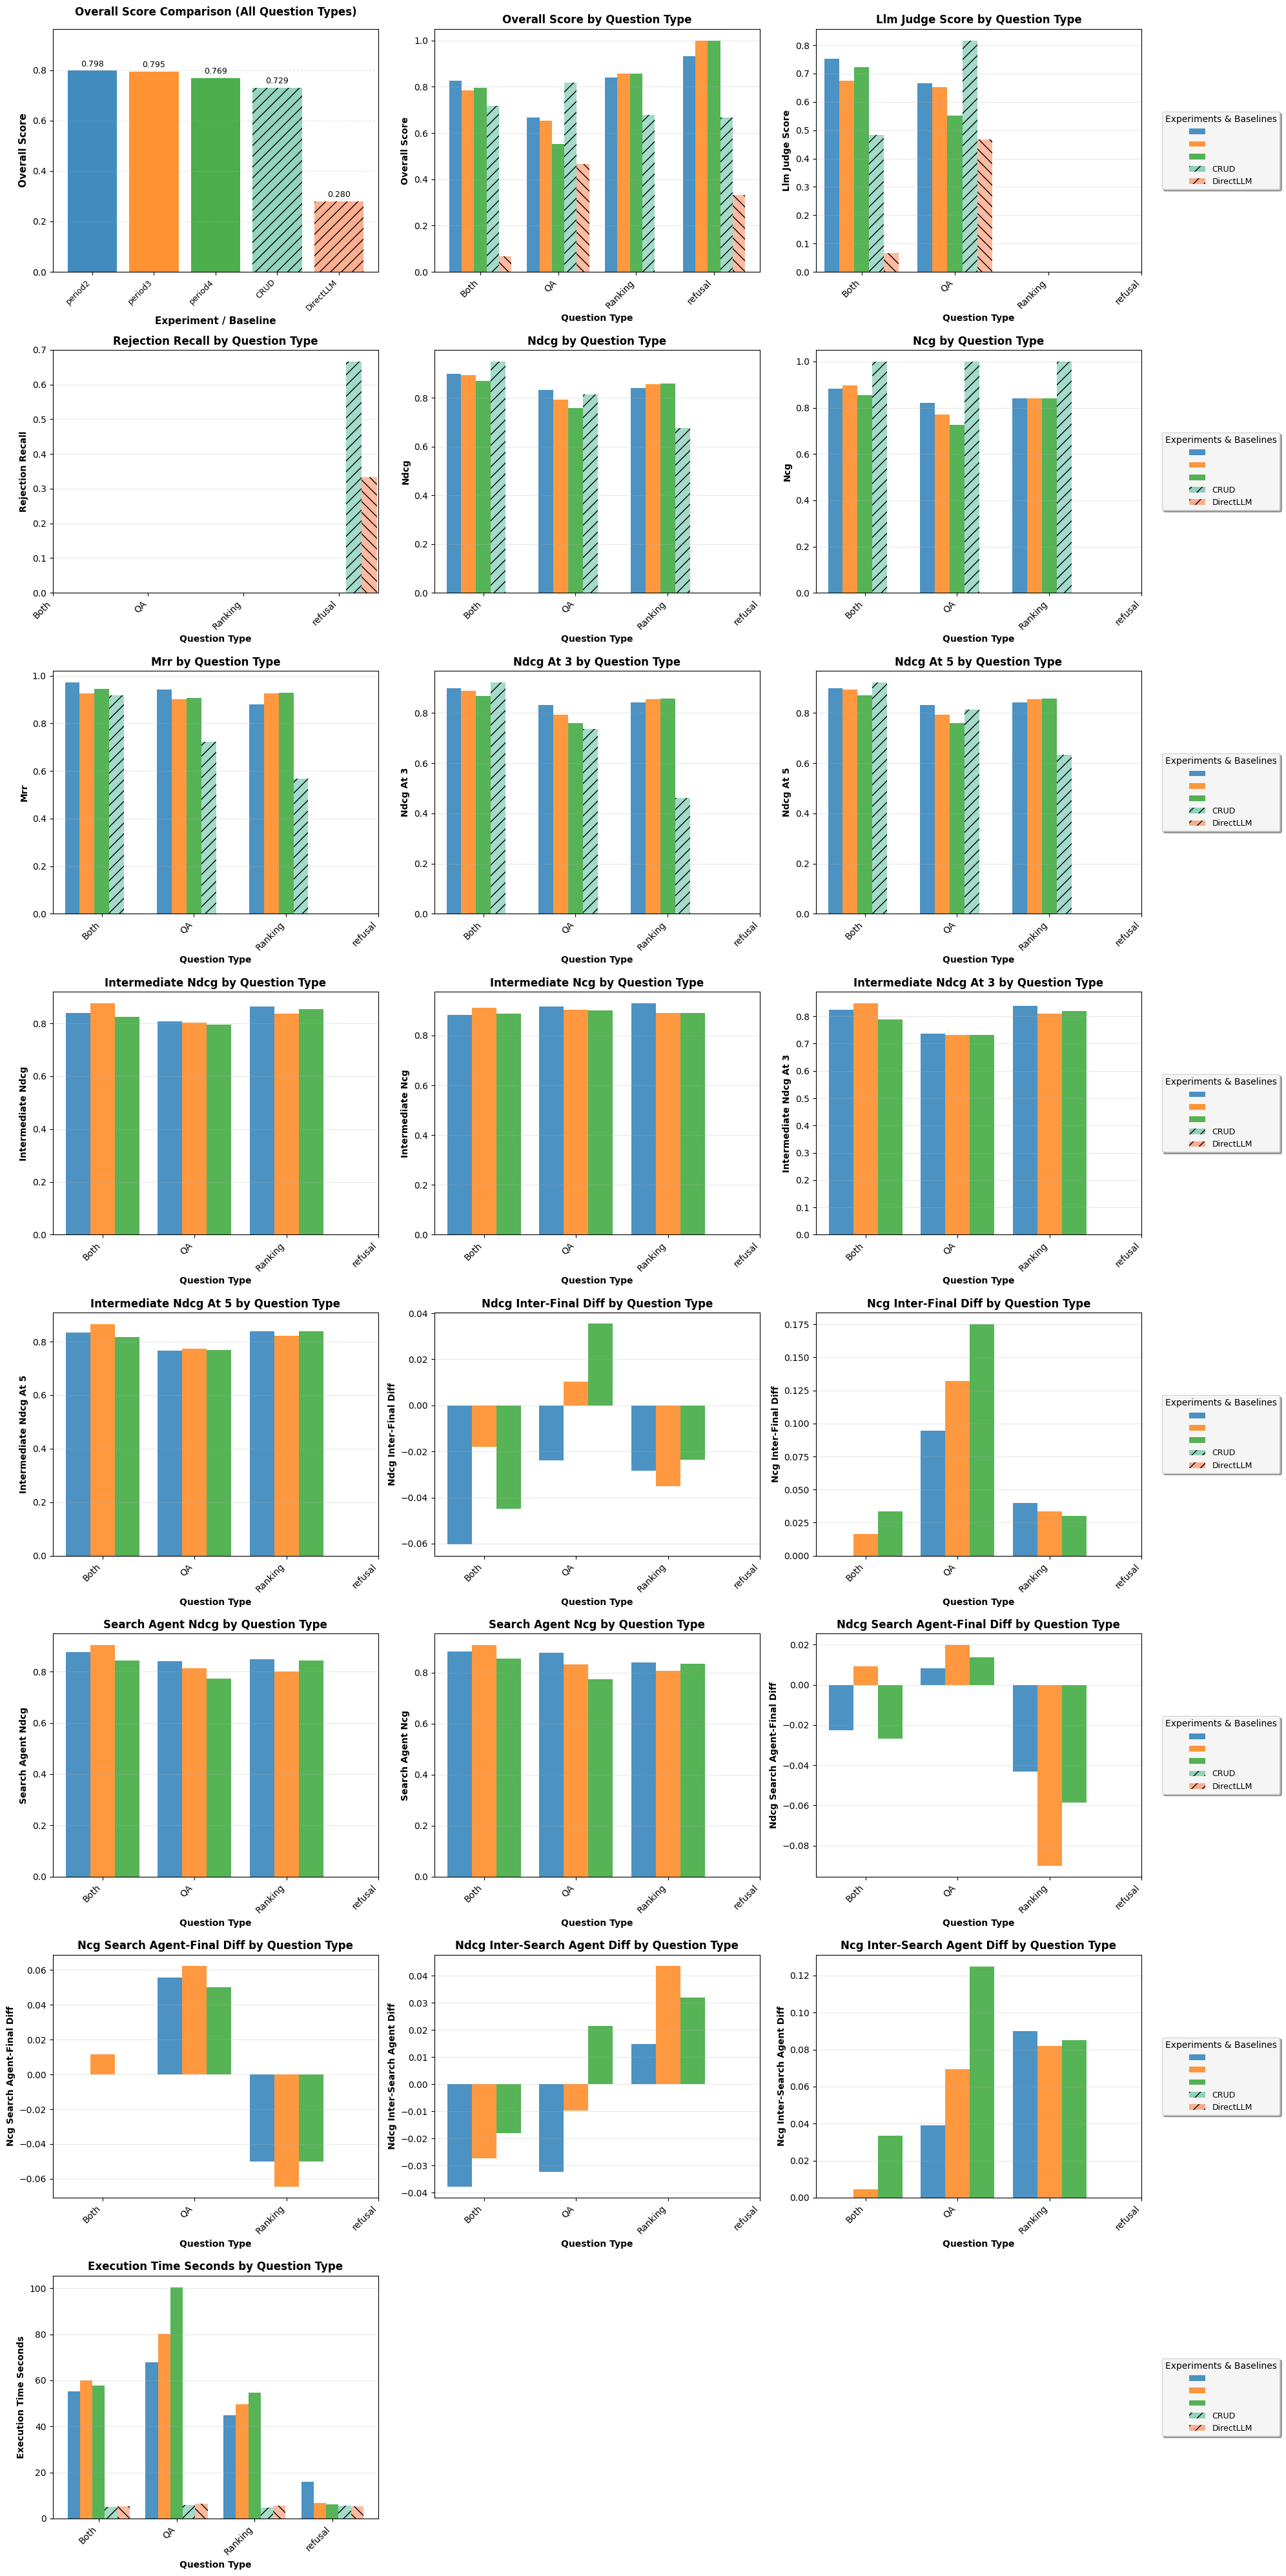


✓ Comparison completed: 22 charts visualized


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Configuration
# results_id = None
results_id = 'separate_corpus_param'
if results_id is None:
    RESULTS_DIR = "../results"
else:
    RESULTS_DIR = os.path.join("../results/aip_saved", results_id)
BASELINE_PATHS = {
    'CRUD': "../results/aip_saved/crud_hybrid_aip_test_20_full_20251121_161550.csv",
    'DirectLLM': "../results/aip_saved/direct_llm_20samples_rag_evaluation_results_20251121_104026.csv"
}

BASELINE_PATHS = {
    'CRUD': "../results/aip_saved/crud_hybrid_aip_test_full_20251121_161550.csv",
    'DirectLLM': "../results/aip_saved/direct_llm_120_samplesrag_evaluation_results_20251121_104114.csv"
}
# Metrics configuration with display names
DEFAULT_METRICS = [
    ('overall_score', 'Overall Score'),
    ('execution_time_seconds', 'Execution Time (s)'),
    ('mrr', 'MRR'),
    ('ndcg', 'NDCG'),
    ('ndcg_at_3', 'NDCG@3'),
    ('ndcg_at_5', 'NDCG@5'),
    ('ncg', 'NCG'),
    ('llm_judge_score', 'LLM Judge'),
    ('intermediate_ndcg', 'Inter-NDCG'),
    ('intermediate_ncg', 'Inter-NCG'),
    ('ndcg_inter-final_diff', 'NDCG Δ'),
    ('ncg_inter-final_diff', 'NCG Δ')
]


def load_baselines():
    """Load baseline experiment results"""
    baselines = {}
    for name, path in BASELINE_PATHS.items():
        if os.path.exists(path):
            df = pd.read_csv(path)
            if 'question_type' in df.columns:
                baselines[name] = df
                print(f"✓ Loaded {name} baseline: {len(df)} samples")
    return baselines


def find_experiments(exp_ids=None, max_experiments=10):
    """Find experiment folders to compare"""
    all_folders = [d for d in os.listdir(RESULTS_DIR) 
                   if os.path.isdir(os.path.join(RESULTS_DIR, d))]
    all_folders.sort(reverse=True)
    print(os.listdir(RESULTS_DIR))
    if exp_ids:
        selected = []
        for exp_id in exp_ids:
            matches = [f for f in all_folders if exp_id in f]
            if matches:
                selected.append(matches[0])
        return selected
    
    return all_folders[:max_experiments]


def extract_timestamp(folder_name):
    """从文件夹名中提取时间戳用于排序
    例如: experiment_aaa_bbb_20251031_170901 -> 20251031_170901
    """
    parts = folder_name.split('_')
    # 查找最后两个部分是否是日期和时间格式
    if len(parts) >= 2:
        # 尝试最后两个部分
        potential_timestamp = f"{parts[-2]}_{parts[-1]}"
        # 简单验证：日期部分应该是8位数字，时间部分应该是6位数字
        if len(parts[-2]) == 8 and parts[-2].isdigit() and len(parts[-1]) == 6 and parts[-1].isdigit():
            return potential_timestamp
    # 如果没有找到时间戳，返回整个文件夹名作为排序键
    return folder_name


def load_experiments(folders):
    """Load experiment data from folders"""
    experiments = []
    for folder in folders:
        exp_path = os.path.join(RESULTS_DIR, folder)
        csv_files = glob.glob(os.path.join(exp_path, "rag_evaluation*.csv"))
        
        if csv_files:
            df = pd.read_csv(csv_files[0])
            if 'question_type' in df.columns:
                experiments.append({
                    'name': folder,
                    'short_name': folder.split('_')[-1][:10],
                    'df': df,
                    'timestamp': extract_timestamp(folder)  # 添加时间戳用于排序
                })
                print(f"✓ Loaded experiment {folder.split('_')[-1][:10]}: {len(df)} samples")
    
    # 按时间戳排序实验（从早到晚，即从左到右）
    experiments.sort(key=lambda x: x['timestamp'])
    
    return experiments


def compare_experiments(exp_ids=None, max_experiments=3, metrics=None, n_cols=3):
    """
    Compare metrics across experiments by question type
    
    Args:
        exp_ids (list): Specific experiment IDs to compare
        max_experiments (int): Max number of latest experiments (if exp_ids not specified)
        metrics (list): Metrics to compare. Can be:
            - None: use DEFAULT_METRICS
            - List of column names: ['mrr', 'ndcg', 'llm_judge_score']
            - List of tuples: [('mrr', 'MRR Score'), ('ndcg', 'NDCG')]
            - Empty list []: use all numeric columns from CSV
        n_cols (int): Number of charts per row
    """
    print("="*80)
    print("Multi-Experiment Comparison")
    print("="*80)
    
    # Load data
    baselines = load_baselines()
    folders = find_experiments(exp_ids, max_experiments)
    
    if not folders:
        print("❌ No experiment folders found")
        return
    
    experiments = load_experiments(folders)
    
    if not experiments:
        print("❌ No valid experiment data loaded")
        return
    
    print(f"📅 Experiments sorted by timestamp (left to right in charts):")
    for exp in experiments:
        print(f"   {exp['timestamp']}: {exp['name']}")
    print()
    
    # 计算所有实验中数值列的交集，但保持第一个实验中的列顺序
    first_exp_numeric_cols = experiments[0]['df'].select_dtypes(include=[np.number]).columns.tolist()
    all_numeric_cols = set(first_exp_numeric_cols)
    
    for exp in experiments[1:]:
        numeric_cols = set(exp['df'].select_dtypes(include=[np.number]).columns.tolist())
        all_numeric_cols = all_numeric_cols.intersection(numeric_cols)
    
    # 保持第一个实验CSV中的列顺序
    available_metrics = [col for col in first_exp_numeric_cols if col in all_numeric_cols]
    
    if not available_metrics:
        print("❌ No common numeric metrics found across all experiments")
        return
    
    print(f"📊 Available metrics (intersection, in CSV order): {len(available_metrics)}")
    print(f"   {', '.join(available_metrics[:10])}" + ("..." if len(available_metrics) > 10 else ""))
    
    # Get all question types
    question_types = set()
    for exp in experiments:
        question_types.update(exp['df']['question_type'].unique())
    question_types = sorted(question_types)
    
    print(f"📝 Question types: {', '.join(question_types)}")
    
    # Check if overall_score exists
    has_overall_score = 'overall_score' in available_metrics
    
    # Create visualization - add 1 extra subplot if overall_score exists
    n_metrics = len(available_metrics)
    total_subplots = n_metrics + (1 if has_overall_score else 0)
    n_rows = (total_subplots + n_cols - 1) // n_cols
    
    # 创建图形时每行留出右边空间给图例
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols + 2, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    current_idx = 0
    
    # 用于收集所有图例项
    legend_handles = []
    legend_labels = []
    
    # Plot overall_score (不区分问题类别) as the first subplot if it exists
    if has_overall_score:
        ax = axes_flat[current_idx]
        current_idx += 1
        
        # Calculate overall scores for each experiment
        exp_overall_scores = []
        for exp in experiments:
            overall_data = exp['df']['overall_score']
            overall_data = pd.to_numeric(overall_data, errors='coerce')
            exp_overall_scores.append(overall_data.mean() if len(overall_data) > 0 else 0)
        
        # Calculate overall scores for baselines
        baseline_overall_scores = []
        baseline_names = []
        for baseline_name, baseline_df in baselines.items():
            if 'overall_score' in baseline_df.columns:
                overall_data = baseline_df['overall_score']
                overall_data = pd.to_numeric(overall_data, errors='coerce')
                baseline_overall_scores.append(overall_data.mean() if len(overall_data) > 0 else 0)
                baseline_names.append(baseline_name)
        
        # Plot bars
        bar_positions = list(range(len(experiments)))
        colors = [plt.cm.tab10(i % 10) for i in range(len(experiments))]
        bars = ax.bar(bar_positions, exp_overall_scores, alpha=0.85, color=colors)
        
        # 收集实验图例项（只收集一次）
        if not legend_handles:
            for exp, bar, color in zip(experiments, bars, colors):
                legend_handles.append(plt.Rectangle((0,0),1,1, fc=color, alpha=0.8))
                legend_labels.append('_'.join(exp['name'].split('_')[1:-2]))
        
        # Add baseline bars
        baseline_start = len(experiments)
        baseline_colors = [plt.cm.Set2(i % 8) for i in range(len(baseline_names))]
        baseline_bars = ax.bar(range(baseline_start, baseline_start + len(baseline_names)), 
                               baseline_overall_scores, alpha=0.7, color=baseline_colors,
                               hatch='//')
        
        # 收集基线图例项（只收集一次）
        if len(legend_handles) == len(experiments):
            for baseline_name, bar, color in zip(baseline_names, baseline_bars, baseline_colors):
                legend_handles.append(plt.Rectangle((0,0),1,1, fc=color, alpha=0.7, hatch='//'))
                legend_labels.append(baseline_name)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, exp_overall_scores)):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, value + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        for i, (bar, value) in enumerate(zip(baseline_bars, baseline_overall_scores)):
            if value > 0:
                ax.text(bar.get_x() + bar.get_width()/2, value + 0.01, 
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)
        
        # Set labels and title
        ax.set_xlabel('Experiment / Baseline', fontweight='bold', fontsize=11)
        ax.set_ylabel('Overall Score', fontweight='bold', fontsize=11)
        ax.set_title('Overall Score Comparison (All Question Types)', fontweight='bold', fontsize=12, pad=15)
        
        # Set x-axis labels
        all_labels = [exp['short_name'] for exp in experiments] + baseline_names
        ax.set_xticks(range(len(all_labels)))
        ax.set_xticklabels(all_labels, rotation=45, ha='right', fontsize=9)
        
        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
        ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
    
    # Plot each metric by question type
    for metric_col in available_metrics:
        metric_title = metric_col.replace('_', ' ').title()
        ax = axes_flat[current_idx]
        current_idx += 1
        
        x_pos = np.arange(len(question_types))
        total_items = len(experiments) + sum(1 for baseline_df in baselines.values() if metric_col in baseline_df.columns)
        width = 0.8 / total_items
        
        # Plot experiments (已经按时间戳排序)
        for exp_idx, exp in enumerate(experiments):
            values = []
            for qtype in question_types:
                qtype_data = exp['df'][exp['df']['question_type'] == qtype][metric_col]
                # Handle non-numeric values (like 'N/A')
                qtype_data = pd.to_numeric(qtype_data, errors='coerce')
                values.append(qtype_data.mean() if len(qtype_data) > 0 else 0)
            
            color = plt.cm.tab10(exp_idx % 10)
            ax.bar(x_pos + exp_idx * width, values, width, 
                   color=color, alpha=0.8)
        
        # Plot baselines (only if they have the metric)
        for baseline_idx, (baseline_name, baseline_df) in enumerate(baselines.items()):
            if metric_col in baseline_df.columns:
                values = []
                for qtype in question_types:
                    qtype_data = baseline_df[baseline_df['question_type'] == qtype][metric_col]
                    qtype_data = pd.to_numeric(qtype_data, errors='coerce')
                    values.append(qtype_data.mean() if len(qtype_data) > 0 else 0)
                
                offset = len(experiments) + baseline_idx
                color = plt.cm.Set2(baseline_idx % 8)
                ax.bar(x_pos + offset * width, values, width, 
                       color=color, alpha=0.6, 
                       hatch='//' if baseline_idx == 0 else '\\\\')
        
        ax.set_xlabel('Question Type', fontweight='bold')
        ax.set_ylabel(metric_title, fontweight='bold')
        ax.set_title(f'{metric_title} by Question Type', fontweight='bold')
        ax.set_xticks(x_pos + width * (total_items - 1) / 2)
        ax.set_xticklabels(question_types, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(current_idx, len(axes_flat)):
        axes_flat[idx].axis('off')
    
    # 为每行添加图例（放在每行的最右边）
    if legend_handles:
        for row in range(n_rows):
            # 计算每行的最后一个子图位置
            last_ax_in_row = axes[row, -1] if n_rows > 1 else axes[-1]
            
            # 在该子图右侧添加图例
            last_ax_in_row.legend(legend_handles, legend_labels,
                                 loc='center left',
                                 bbox_to_anchor=(1.05, 0.5),
                                 fontsize=9,
                                 frameon=True,
                                 fancybox=True,
                                 shadow=True,
                                 framealpha=0.9,
                                 title='Experiments & Baselines',
                                 title_fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Comparison completed: {total_subplots} charts visualized")

# Example usage
if __name__ == "__main__":
    # Compare latest 3 experiments with default metrics
    compare_experiments(max_experiments=10)
    
    # Example: Compare specific experiments
    # compare_experiments(exp_ids=['save_checklist_split_period3', 'not_save_checklist_split_period3'])
    
    # Example: Compare with custom metrics
    # compare_experiments(metrics=['mrr', 'ndcg', 'llm_judge_score'])
    
    # Example: Compare with all available metrics from CSV
    # compare_experiments(metrics=[])


In [11]:
### save the whole notebook to experiment folder with embedded images
def create_html_report_stable(experiment_folder):
    try:
        import os
        import nbformat
        from nbconvert import HTMLExporter
        from nbconvert.preprocessors import ExecutePreprocessor
        from traitlets.config import Config
        
        # 获取当前 notebook 路径
        import ipynbname
        notebook_path = ipynbname.path()
        notebook_name = os.path.basename(notebook_path)
        name_without_ext = os.path.splitext(notebook_name)[0]
        
        # 确保实验文件夹存在
        experiment_folder = os.path.abspath(experiment_folder)
        os.makedirs(experiment_folder, exist_ok=True)
        
        # 读取 notebook
        with open(notebook_path, 'r', encoding='utf-8') as f:
            notebook_content = nbformat.read(f, as_version=4)
        
        # 配置转换器
        c = Config()
        # 隐藏代码输入但保留输出（包括图表）
        c.HTMLExporter.exclude_input = True
        c.HTMLExporter.exclude_output_prompt = True
        c.HTMLExporter.exclude_input_prompt = True
        
        # 关键设置：将图片嵌入到HTML中（base64编码）
        c.HTMLExporter.embed_images = True
        
        # 创建转换器
        html_exporter = HTMLExporter(config=c)
        
        # 转换 notebook
        (body, resources) = html_exporter.from_notebook_node(notebook_content)
        
        # 写入HTML文件（单文件，图片已嵌入）
        html_filename = f"{name_without_ext}_report.html"
        html_path = os.path.join(experiment_folder, html_filename)
        
        with open(html_path, 'w', encoding='utf-8') as f:
            f.write(body)
        
        print(f"✅ 已创建HTML报告（包含嵌入式图表）: {html_path}")
        print(f"📊 报告中包含 markdown 和所有输出（图表已嵌入），代码已隐藏")
        print(f"📁 文件大小: {os.path.getsize(html_path) / 1024:.2f} KB")
        
        return html_path
        
    except Exception as e:
        print(f"创建 HTML 报告时出错: {e}")
        import traceback
        print(f"详细错误: {traceback.format_exc()}")
        return None



In [12]:
# 使用
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# create_html_report_stable(f'/home/dyvm6xra/dyvm6xrauser44/wujiamin/AgenticRAG/rag_exp/comparison/{timestamp}/')